# **Project: 8 Weeks SQL Challenge - Case #2: Pizza Runner**

## **Data Cleaning**

In [1]:
import yaml
import pandas as pd
import sqlalchemy

with open("config.yaml","r") as file_obj:
    config = yaml.load(file_obj, Loader= yaml.SafeLoader)

conn_string = f'mysql+pymysql://{config["database_server"]["user"]}:{config["database_server"]["password"]}@{config["database_server"]["host"]}/{config["database_server"]["database"]}'
myengine = sqlalchemy.create_engine(conn_string)

#myengine.dispose()

In [17]:
def query_res(sql_statement):
    print(pd.read_sql(sql_statement, con=myengine))

query_res("show tables")

  Tables_in_pp_8wsc_pizza_runner
0                customer_orders
1                    pizza_names
2                  pizza_recipes
3                 pizza_toppings
4                  runner_orders
5                        runners


In [24]:
for tbl in pd.read_sql("show tables", con=myengine)["Tables_in_pp_8wsc_pizza_runner"]:
    print(tbl)
    query_res(f"describe {tbl}")
    print("-"*10)

customer_orders
         Field        Type Null  Key Default Extra
0     order_id         int  YES  MUL    None      
1  customer_id         int  YES         None      
2     pizza_id         int  YES  MUL    None      
3   exclusions  varchar(4)  YES         None      
4       extras  varchar(4)  YES         None      
5   order_time   timestamp  YES         None      
----------
pizza_names
        Field  Type Null  Key Default Extra
0    pizza_id   int   NO  PRI    None      
1  pizza_name  text  YES         None      
----------
pizza_recipes
      Field  Type Null  Key Default Extra
0  pizza_id   int  YES  MUL    None      
1  toppings  text  YES         None      
----------
pizza_toppings
          Field  Type Null  Key Default Extra
0    topping_id   int   NO  PRI    None      
1  topping_name  text  YES         None      
----------
runner_orders
              Field         Type Null  Key Default Extra
0          order_id          int   NO  PRI    None      
1         runner_i

## A. Pizza Metrics
- How many pizzas were ordered?
- How many unique customer orders were made?
- How many successful orders were delivered by each runner?
- How many of each type of pizza was delivered?
- How many Vegetarian and Meatlovers were ordered by each customer?
- What was the maximum number of pizzas delivered in a single order?
- For each customer, how many delivered pizzas had at least 1 change and how many had no changes?
- How many pizzas were delivered that had both exclusions and extras?
- What was the total volume of pizzas ordered for each hour of the day?
- What was the volume of orders for each day of the week?


In [38]:
query_res( "select count(*) as Total_pizzas_ordered from customer_orders;")

   Total_pizzas_ordered
0                    14


In [37]:
query_res( "select count(distinct order_id) as Total_orders from customer_orders;")

   Total_orders
0            10


In [36]:
query_res("""
    select runner_id, count(distinct order_id) as Total_sucessfully_delivered_orders
    from runner_orders
    where cancellation is NULL
    group by runner_id;
""")



   runner_id  Total_sucessfully_delivered_orders
0          1                                   4
1          2                                   3
2          3                                   1


In [47]:
query_res("""
    select 
        co.pizza_id
        , pi.pizza_name 
        , count(*) as Total_sucessfully_delivered_pizzas
    from customer_orders co
    join runner_orders ro
        on co.order_id = ro.order_id
            and ro.cancellation is NULL
    left join pizza_names pi
        on co.pizza_id = pi.pizza_id
    group by 1,2;
""")

   pizza_id  pizza_name  Total_sucessfully_delivered_pizzas
0         1  Meatlovers                                   9
1         2  Vegetarian                                   3


In [48]:
query_res("""
    select 
        co.customer_id
        , pi.pizza_name 
        , count(co.order_id) as Total_ordered
        , count(ro.order_id) as Total_sucessfully_delivered
    from customer_orders co
    cross join pizza_names pi
        on co.pizza_id = pi.pizza_id
    left join runner_orders ro
        on co.order_id = ro.order_id
          and ro.cancellation is NULL
    group by 1,2
    order by co.customer_id, pi.pizza_name
    ;
""")

   customer_id  pizza_name  Total_ordered  Total_sucessfully_delivered
0          101  Meatlovers              2                            2
1          101  Vegetarian              1                            0
2          102  Meatlovers              2                            2
3          102  Vegetarian              1                            1
4          103  Meatlovers              3                            2
5          103  Vegetarian              1                            1
6          104  Meatlovers              3                            3
7          105  Vegetarian              1                            1


In [49]:
query_res("""
    select 
        co.order_id
        , count(*) as Total_sucessfully_delivered_pizzas
    from customer_orders co
    join runner_orders ro
        on co.order_id = ro.order_id
            and ro.cancellation is NULL
    group by co.order_id
    order by Total_sucessfully_delivered_pizzas desc
    limit 1;
""")

   order_id  Total_sucessfully_delivered_pizzas
0         4                                   3


In [59]:
query_res("""
select
    case when exclusions is not null or extras is not null then "Has Change(s)"
    else "No Change" end as Has_change,
    count(*) as Total_ordered_pizzas
from customer_orders
group by Has_change;
""")

      Has_change  Total_ordered_pizzas
0      No Change                     7
1  Has Change(s)                     7


In [60]:
query_res("""
select
    count(*) as Total_delivered_pizzas_with_both_exclusions_extras
from customer_orders co
join runner_orders ro
    on co.order_id = ro.order_id
        and ro.cancellation is null
where 
    exclusions is not null 
    and extras is not null;
""")

   Total_delivered_pizzas_with_both_exclusions_extras
0                                                  1 


In [ ]:
query_res("""
select 
    hour(order_time) as Hour_of_day
    , count(*) as Total_ordered_pizzas
from customer_orders
group by Hour_of_day
order by Hour_of_day;
""")

   Hour_of_day  Total_ordered_pizzas
0           11                     1
1           13                     3
2           18                     3
3           19                     1
4           21                     3
5           23                     3


In [74]:
query_res("""
select 
    date_format(order_time, '%%W') as Day_of_week
    , count(*) as Total_ordered_pizzas
from customer_orders
group by Day_of_week
order by Day_of_week;
""")

  Day_of_week  Total_ordered_pizzas
0      Friday                     1
1    Saturday                     5
2    Thursday                     3
3   Wednesday                     5



## B. Runner and Customer Experience
- How many runners signed up for each 1 week period? - (i.e. week starts 2021-01-01)
- What was the average time in minutes it took for each runner to arrive at the Pizza Runner HQ to pickup the order?
- Is there any relationship between the number of pizzas and how long the order takes to prepare?
- What was the average distance travelled for each customer?
- What was the difference between the longest and shortest delivery times for all orders?
- What was the average speed for each runner for each delivery and do you notice any trend for these values?
- What is the successful delivery percentage for each runner?


In [75]:
query_res("""
select
    date_sub(registration_date, 
        interval dayofweek(registration_date) - 1 day ) 
    as Week_of_sunday
    , count(*) as Total_registered_runners
from runners
group by Week_of_sunday
""")

  Week_of_sunday  Total_registered_runners
0     2020-12-27                         1
1     2021-01-03                         2
2     2021-01-10                         1


In [80]:
query_res("""
select avg(timestampdiff(minute, order_time, pickup_time)) as Avg_minutes_order_to_pickup
from runner_orders ro
left join (
    select distinct order_id, order_time
    from customer_orders
    ) co
on ro.order_id = co.order_id
where pickup_time is not null;
""")

   Avg_minutes_order_to_pickup
0                       15.625


<Axes: xlabel='Pizzas_ordered', ylabel='Minutes_order_to_pickup'>

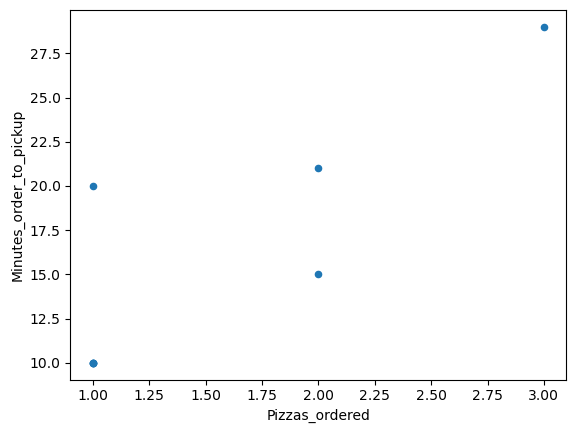

In [113]:
df_pizza_v_pickup = pd.read_sql(""" 
select 
    co.Pizzas_ordered
    , timestampdiff(minute, co.order_time, ro.pickup_time) as Minutes_order_to_pickup
from runner_orders ro
left join (
    select order_id, order_time, count(*) as Pizzas_ordered
    from customer_orders
    group by 1, 2
    ) co
on ro.order_id = co.order_id
where pickup_time is not null;
"""
, con=myengine)
df_pizza_v_pickup.plot.scatter( x = "Pizzas_ordered", y = "Minutes_order_to_pickup" )

In [88]:
query_res(""" 
with co as (
    select distinct order_id, customer_id
    from customer_orders          
)
select 
    customer_id as Customer
    , avg(distance_km) as Avg_distance
from co
join runner_orders ro
    on co.order_id = ro.order_id
    and cancellation is null
group by customer_id;
""")

   Customer  Avg_distance
0       101          20.0
1       102          18.4
2       103          23.4
3       104          10.0
4       105          25.0


In [96]:
query_res("""
select max(duration_minutes) - min(duration_minutes) as Duration_range
from runner_orders
where cancellation is null;
""")

   Duration_range
0            30.0


   runner_id  order_id  Speed_km_minute
0          2         4             0.58
1          1         1             0.62
2          1         3             0.67
3          3         5             0.67
4          1         2             0.74
5          2         7             1.00
6          1        10             1.00
7          2         8             1.56


<Axes: xlabel='runner_id', ylabel='Speed_km_minute'>

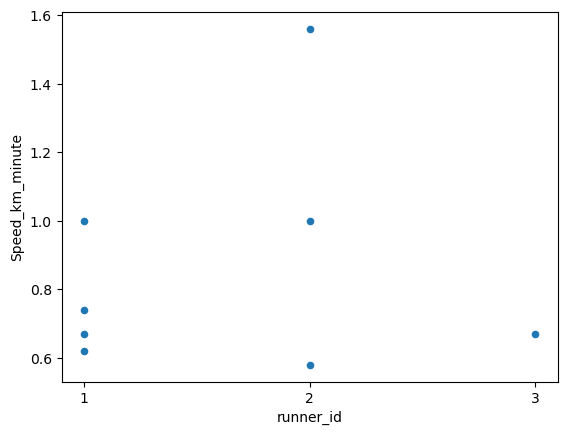

In [114]:
df_delivery_speed = pd.read_sql("""
select 
    runner_id
    , order_id
    , round( distance_km / duration_minutes, 2) as Speed_km_minute
from runner_orders
where cancellation is null
order by Speed_km_minute;
""", con = myengine)
print(df_delivery_speed)
df_delivery_speed["runner_id"] = df_delivery_speed["runner_id"].astype("string")

df_delivery_speed.sort_values(by="runner_id").plot.scatter(x="runner_id"
                               , y="Speed_km_minute")

In [115]:
query_res("""
select
    runner_id
    , count(pickup_time) * 100 / count(runner_id) as Successful_delivery_perc
from runner_orders
group by runner_id;
""")

   runner_id  Successful_delivery_perc
0          1                     100.0
1          2                      75.0
2          3                      50.0



## C. Ingredient Optimisation
- What are the standard ingredients for each pizza?
- What was the most commonly added extra?
- What was the most common exclusion?
- Generate an order item for each record in the customers_orders table in the format of one of the following:
    - Meat Lovers
    - Meat Lovers - Exclude Beef
    - Meat Lovers - Extra Bacon
    - Meat Lovers - Exclude Cheese, Bacon - Extra Mushroom, Peppers
- Generate an alphabetically ordered comma separated ingredient list for each pizza order from the customer_orders table and add a 2x in front of any relevant ingredients
    - For example: "Meat Lovers: 2xBacon, Beef, ... , Salami"
- What is the total quantity of each ingredient used in all delivered pizzas sorted by most frequent first?



## D. Pricing and Ratings
- If a Meat Lovers pizza costs $12 and Vegetarian costs $10 and there were no charges for changes - how much money has Pizza Runner made so far if there are no delivery fees?
- What if there was an additional $1 charge for any pizza extras?
    - Add cheese is $1 extra
- The Pizza Runner team now wants to add an additional ratings system that allows customers to rate their runner, how would you design an additional table for this new dataset
    - Generate a schema for this new table and insert your own data for ratings for each successful customer order between 1 to 5.
- Using your newly generated table - can you join all of the information together to form a table which has the following information for successful deliveries?
    - customer_id
    - order_id
    - runner_id
    - rating
    - order_time
    - pickup_time
    - Time between order and pickup
    - Delivery duration
    - Average speed
    - Total number of pizzas
- If a Meat Lovers pizza was $12 and Vegetarian $10 fixed prices with no cost for extras and each runner is paid $0.30 per kilometre traveled - how much money does Pizza Runner have left over after these deliveries?



## E. Bonus Questions
If Danny wants to expand his range of pizzas 
- How would this impact the existing data design?
- Write an INSERT statement to demonstrate what would happen if a new Supreme pizza with all the toppings was added to the Pizza Runner menu? 